In [2]:
!pip install ultralytics pycocotools lightly pytorch-lightning -q
print("✅ Libraries (ultralytics, lightly, pytorch-lightning) installed successfully.")

import os
import yaml
import torch
import glob
import shutil
import pytorch_lightning as pl
from ultralytics import YOLO
from lightly.data import LightlyDataset
from lightly.transforms import DINOTransform
from lightly.models.modules import DINOProjectionHead
from lightly.loss import DINOLoss
from IPython.display import Image, display
import copy

✅ Libraries (ultralytics, lightly, pytorch-lightning) installed successfully.


In [3]:
dataset_base_path = '/kaggle/input/medical-image-dataset-brain-tumor-detection/BrainTumor/BrainTumorYolov8'
ssl_train_images = os.path.join(dataset_base_path, 'train/images')

config_path = '/kaggle/working/brain_tumor_data.yaml'
data_config = {
    'path': dataset_base_path,
    'train': 'train/images', 'val': 'valid/images', 'test': 'test/images',
    'names': { 0: 'glioma', 1: 'meningioma', 2: 'pituitary' }
}
with open(config_path, 'w') as f:
    yaml.dump(data_config, f)
print("✅ Dataset configuration file created.")

✅ Dataset configuration file created.


In [4]:
print("\n🔬 Starting Stage 1: SSL Pre-training with DINO...")

# Load a standard YOLOv8n model to extract its backbone
base_model = YOLO('yolov8n.pt')
backbone = base_model.model.model[:10]

# Define the DINO model architecture using the YOLO backbone
class DINO_YOLO(torch.nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
        # The output features from the YOLOv8n backbone's 10th layer have 256 channels
        self.projection_head = DINOProjectionHead(256, 2048, 256, 2048)

    def forward(self, x):
        feature_map = self.backbone(x)
        feature_vector = self.avgpool(feature_map).flatten(start_dim=1)
        projection = self.projection_head(feature_vector)
        return projection

# Define the PyTorch Lightning module for DINO training
class DINO_Lightning(pl.LightningModule):
    def __init__(self, backbone):
        super().__init__()
        self.student_network = DINO_YOLO(backbone)
        
        # FIXED: Instead of using copy.deepcopy(), which causes errors, we instantiate
        # a new teacher network and manually load the student's initial weights.
        # This is a robust method to avoid the deepcopy issue with weight normalization.
        self.teacher_network = DINO_YOLO(backbone)
        self.teacher_network.load_state_dict(self.student_network.state_dict())
        
        self.criterion = DINOLoss(output_dim=2048)
        self.momentum_val = 0.99

    def forward(self, x):
        return self.student_network(x)

    def training_step(self, batch, batch_idx):
        # Momentum update for the teacher network
        self.update_teacher_network()
        
        views, _, _ = batch
        student_out = [self.student_network(view) for view in views]
        
        with torch.no_grad():
            teacher_out = [self.teacher_network(view) for view in views]
        
        loss = self.criterion(student_out, teacher_out, epoch=self.current_epoch)
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.student_network.parameters(), lr=0.05)
        return optimizer
        
    def update_teacher_network(self):
        for param_student, param_teacher in zip(self.student_network.parameters(), self.teacher_network.parameters()):
            param_teacher.data = self.momentum_val * param_teacher.data + (1.0 - self.momentum_val) * param_student.data

# Instantiate the custom Lightning module
dino_lightning_model = DINO_Lightning(backbone)

# Set up the data pipeline for SSL. DINO uses its own set of augmentations.
transform = DINOTransform()
ssl_dataset = LightlyDataset(input_dir=ssl_train_images, transform=transform)
ssl_dataloader = torch.utils.data.DataLoader(ssl_dataset, batch_size=16, shuffle=True, num_workers=2)

# Set up the PyTorch Lightning trainer for the SSL phase
ssl_trainer = pl.Trainer(max_epochs=20, accelerator='gpu', devices=1)

# Train the DINO model
ssl_trainer.fit(dino_lightning_model, ssl_dataloader)

# Save the weights of the pre-trained backbone
pretrained_backbone_weights = '/kaggle/working/dino_backbone.pth'
# We save the backbone of the 'student_network' as it has been trained
torch.save(dino_lightning_model.student_network.backbone.state_dict(), pretrained_backbone_weights)

print(f"✅ SSL Pre-training complete. Backbone weights saved to {pretrained_backbone_weights}")




🔬 Starting Stage 1: SSL Pre-training with DINO...


/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
E0000 00:00:1756523408.933480      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756523409.002498      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Training: |          | 0/? [00:00<?, ?it/s]

✅ SSL Pre-training complete. Backbone weights saved to /kaggle/working/dino_backbone.pth


In [5]:
print("\n🎯 Starting Stage 2: Fine-tuning for Object Detection...")

# Load a fresh YOLOv8n model
finetune_model = YOLO('yolov8n.pt')

# Load our SSL-trained backbone weights into this new model
finetune_model.model.model[:10].load_state_dict(torch.load(pretrained_backbone_weights))
print("✅ SSL pre-trained backbone weights loaded into YOLOv11 model.")

# Now, train the full model on the labeled object detection task
results = finetune_model.train(
    data=config_path,
    epochs=20,
    imgsz=640,
    batch=-1,
    device=0,
    project='ssl_finetune_training',
    name='dino_yolov11'
)



🎯 Starting Stage 2: Fine-tuning for Object Detection...
✅ SSL pre-trained backbone weights loaded into YOLOv11 model.
Ultralytics 8.3.189 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=-1, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/brain_tumor_data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=dino_yolov11, nbs=64, nms=Fa

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        612        612      0.888      0.832      0.908      0.699
                glioma        285        285        0.8       0.69      0.796      0.535
            meningioma        142        142      0.955       0.93      0.979      0.818
             pituitary        185        185      0.909      0.876       0.95      0.745
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to ssl_finetune_training/dino_yolov11


In [6]:
print("\n🔎 Starting final validation for the DINO SSL Model...")
val_results = finetune_model.val(
    split='test',
    project='ssl_finetune_validation',
    name='test_results_dino'
)



🔎 Starting final validation for the DINO SSL Model...
Ultralytics 8.3.189 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 8.1±1.0 MB/s, size: 31.1 KB)
val: Scanning /kaggle/input/medical-image-dataset-brain-tumor-detection/BrainTumor/BrainTumorYolov8/test/labels... 308 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 308/308 263.5it/s 1.2s
WARNING ⚠️ val: Cache directory /kaggle/input/medical-image-dataset-brain-tumor-detection/BrainTumor/BrainTumorYolov8/test is not writeable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 6/6 1.1it/s 5.6ss


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        308        308      0.832      0.825      0.894      0.677
                glioma        159        159      0.708      0.671       0.76      0.497
            meningioma         62         62      0.848      0.919      0.958      0.814
             pituitary         87         87      0.939      0.886      0.965       0.72
Speed: 3.5ms preprocess, 4.7ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to ssl_finetune_validation/test_results_dino



 Displaying results from: ssl_finetune_training/dino_yolov11 ---

📊 Training & Validation Metrics


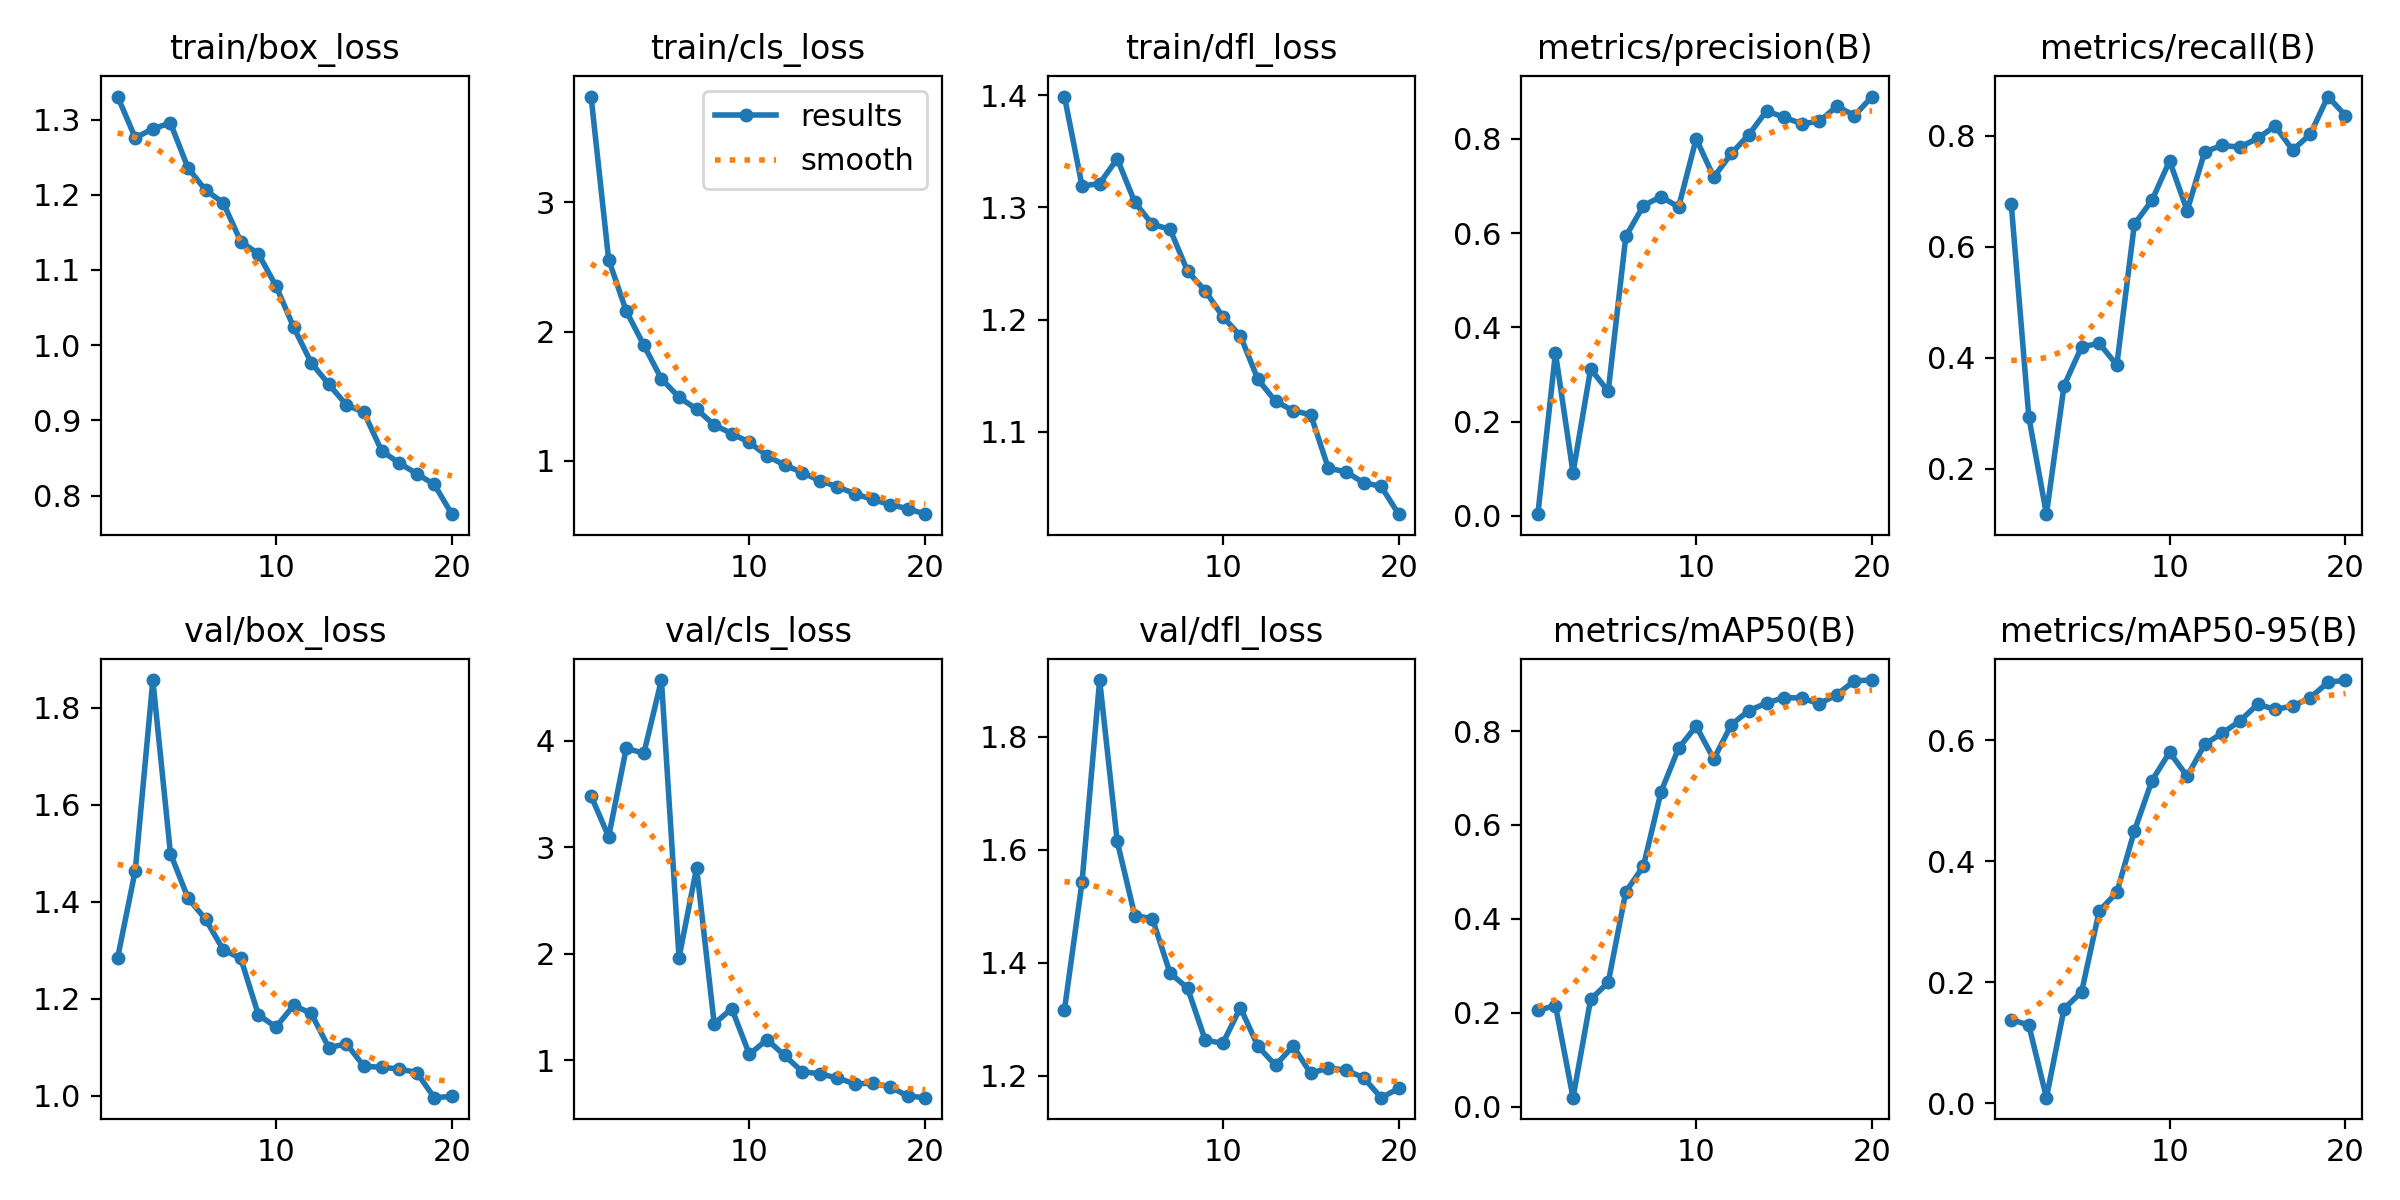


🔀 Confusion Matrix


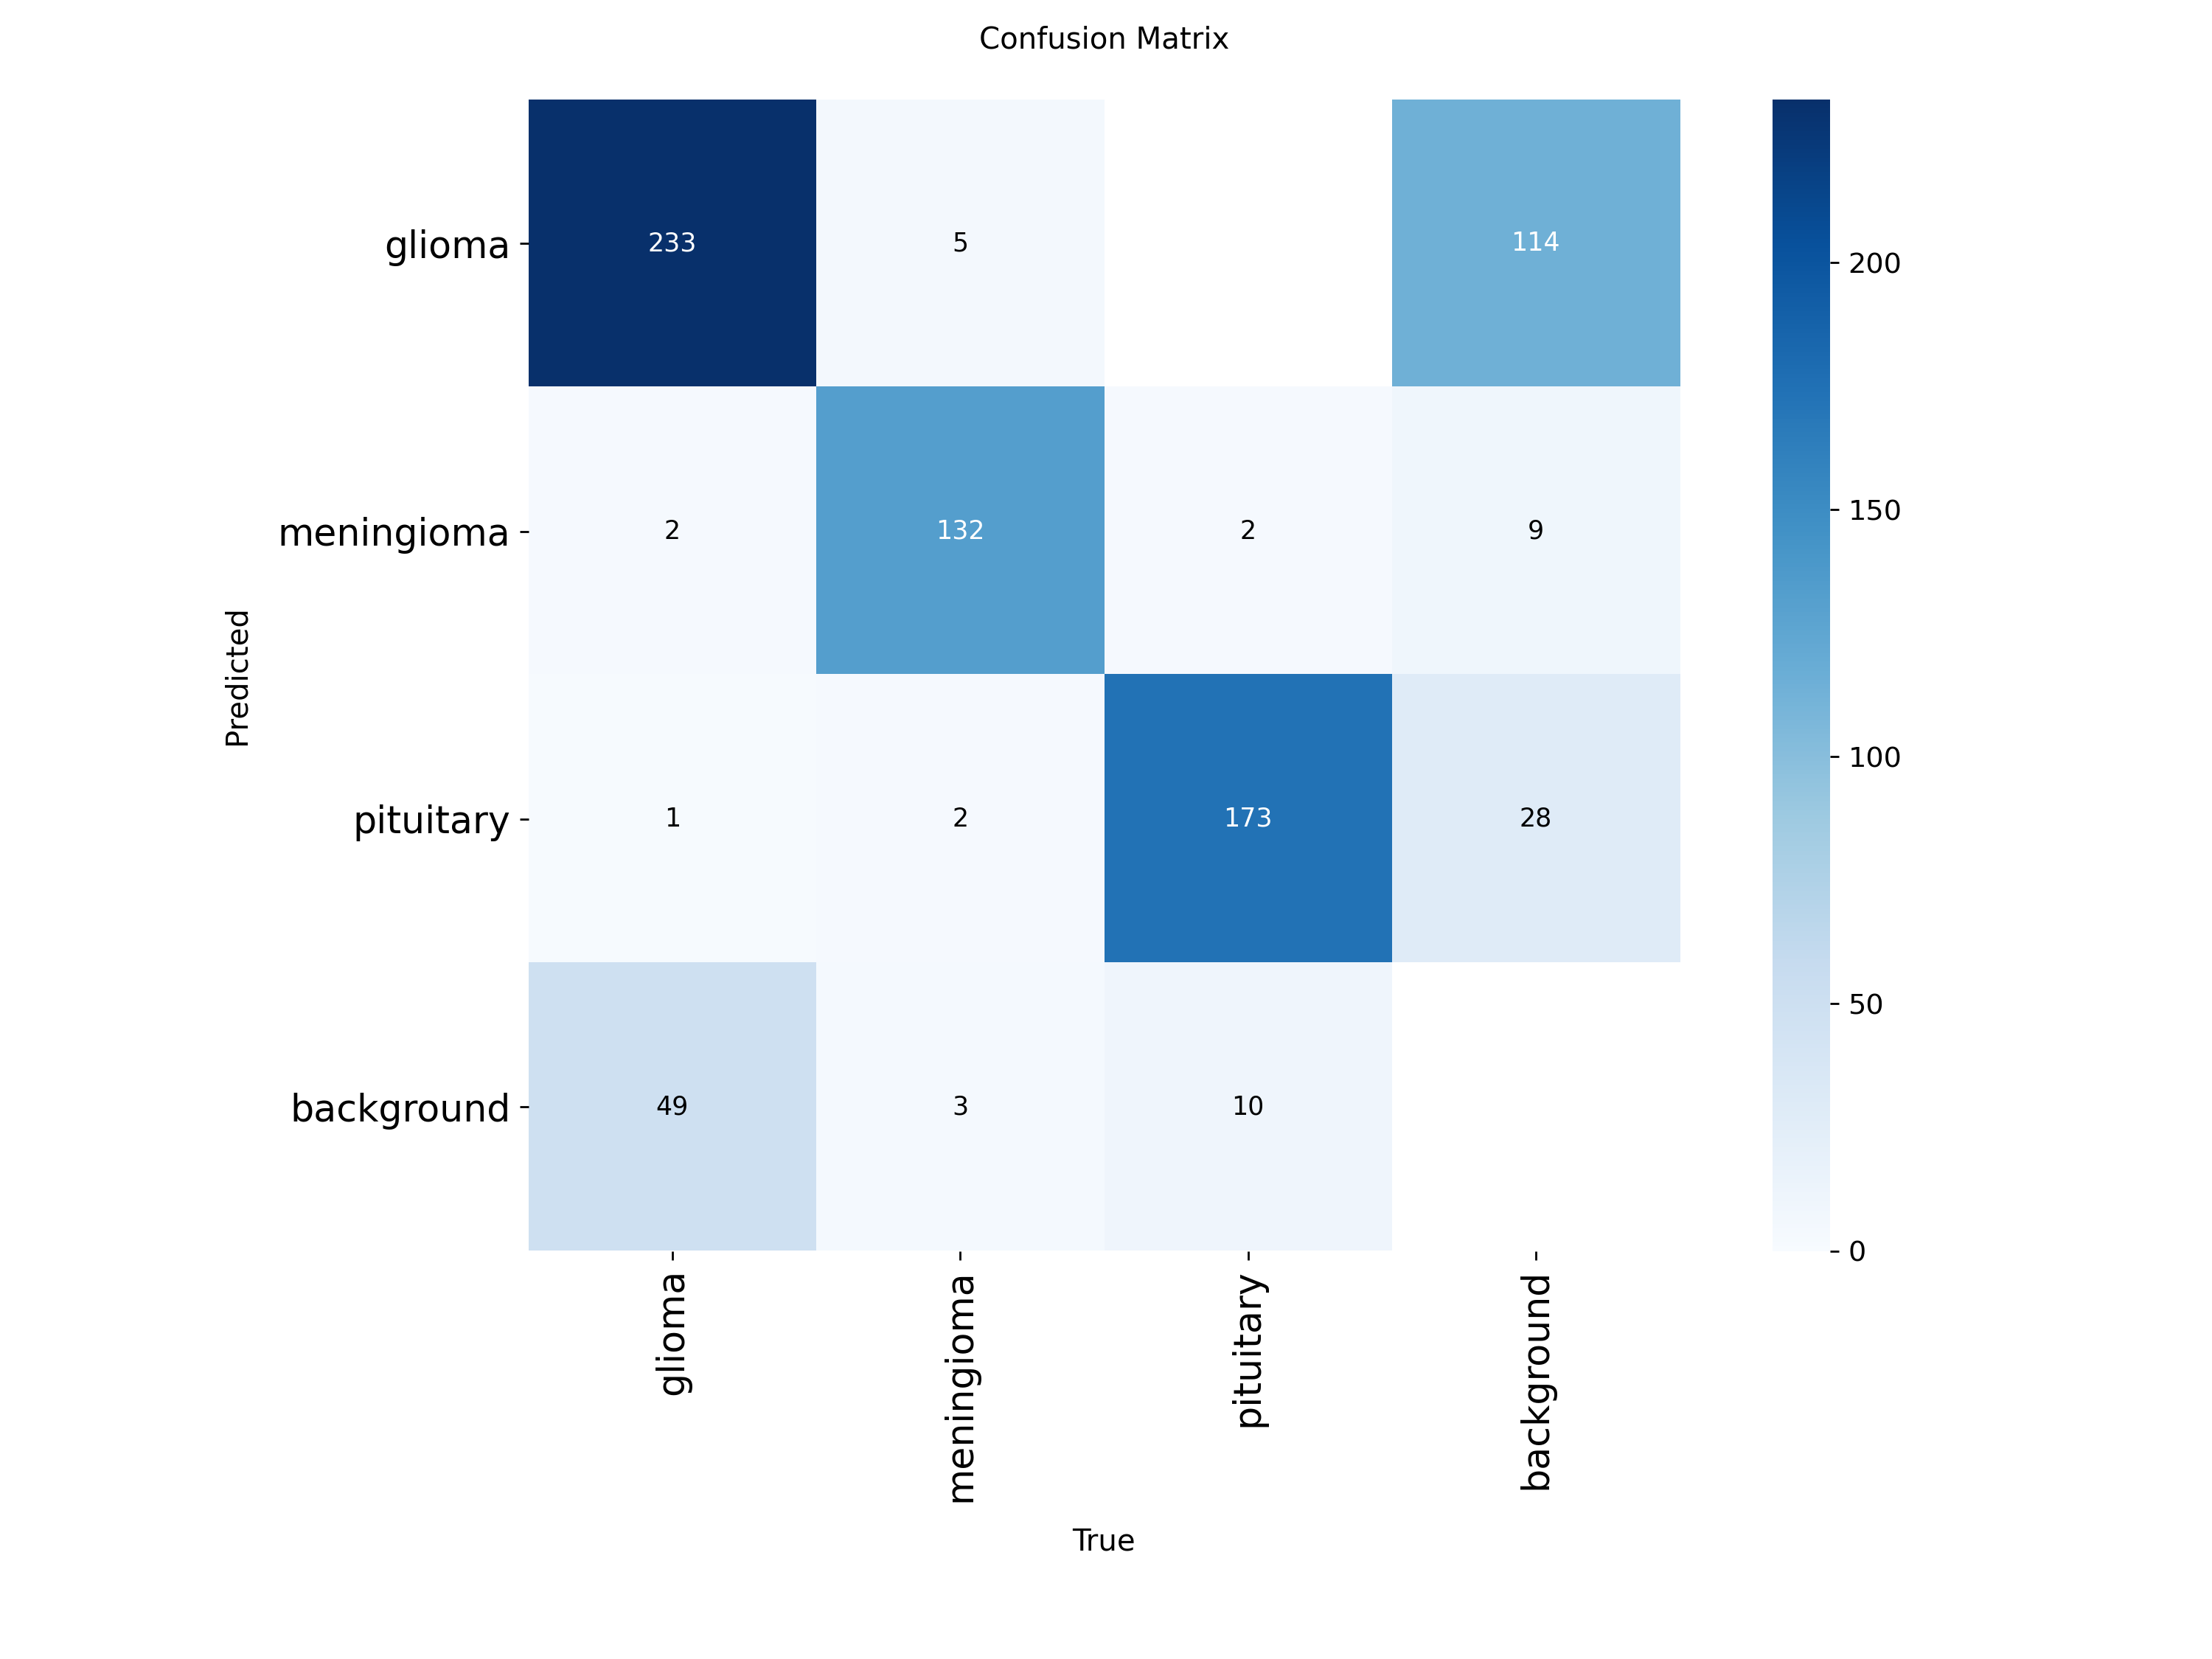


🖼️ Sample Predictions from Validation


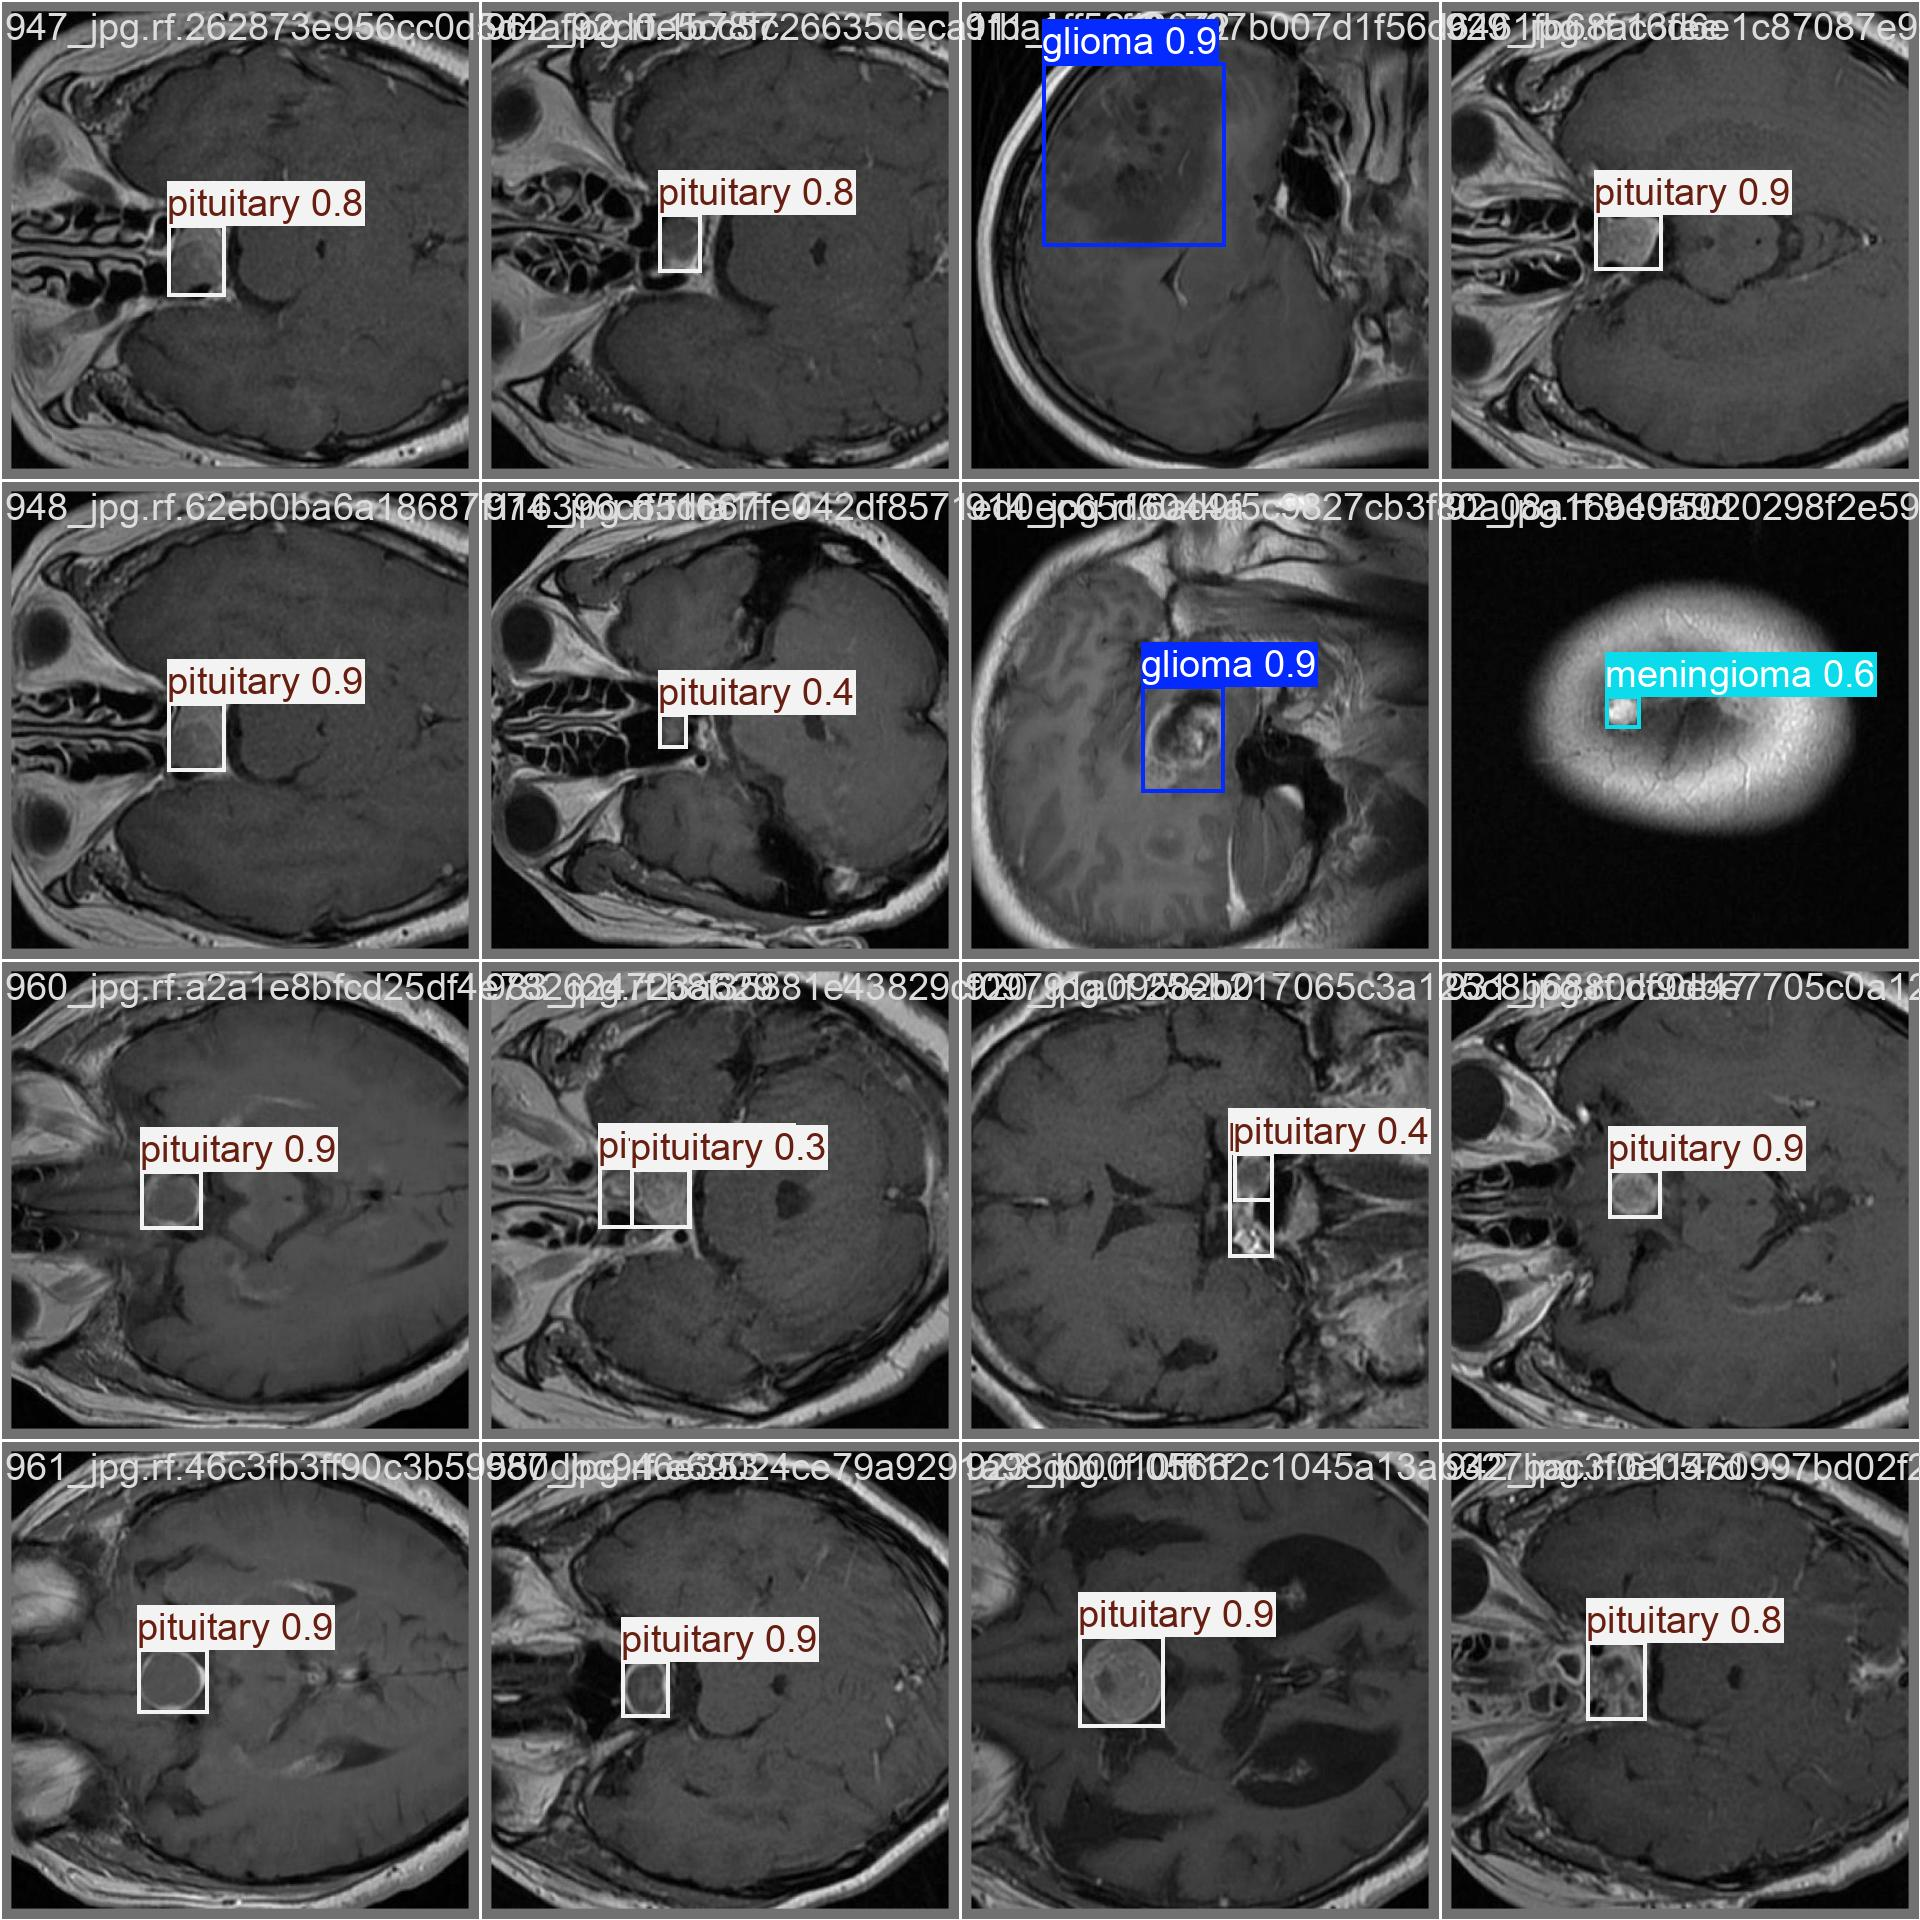

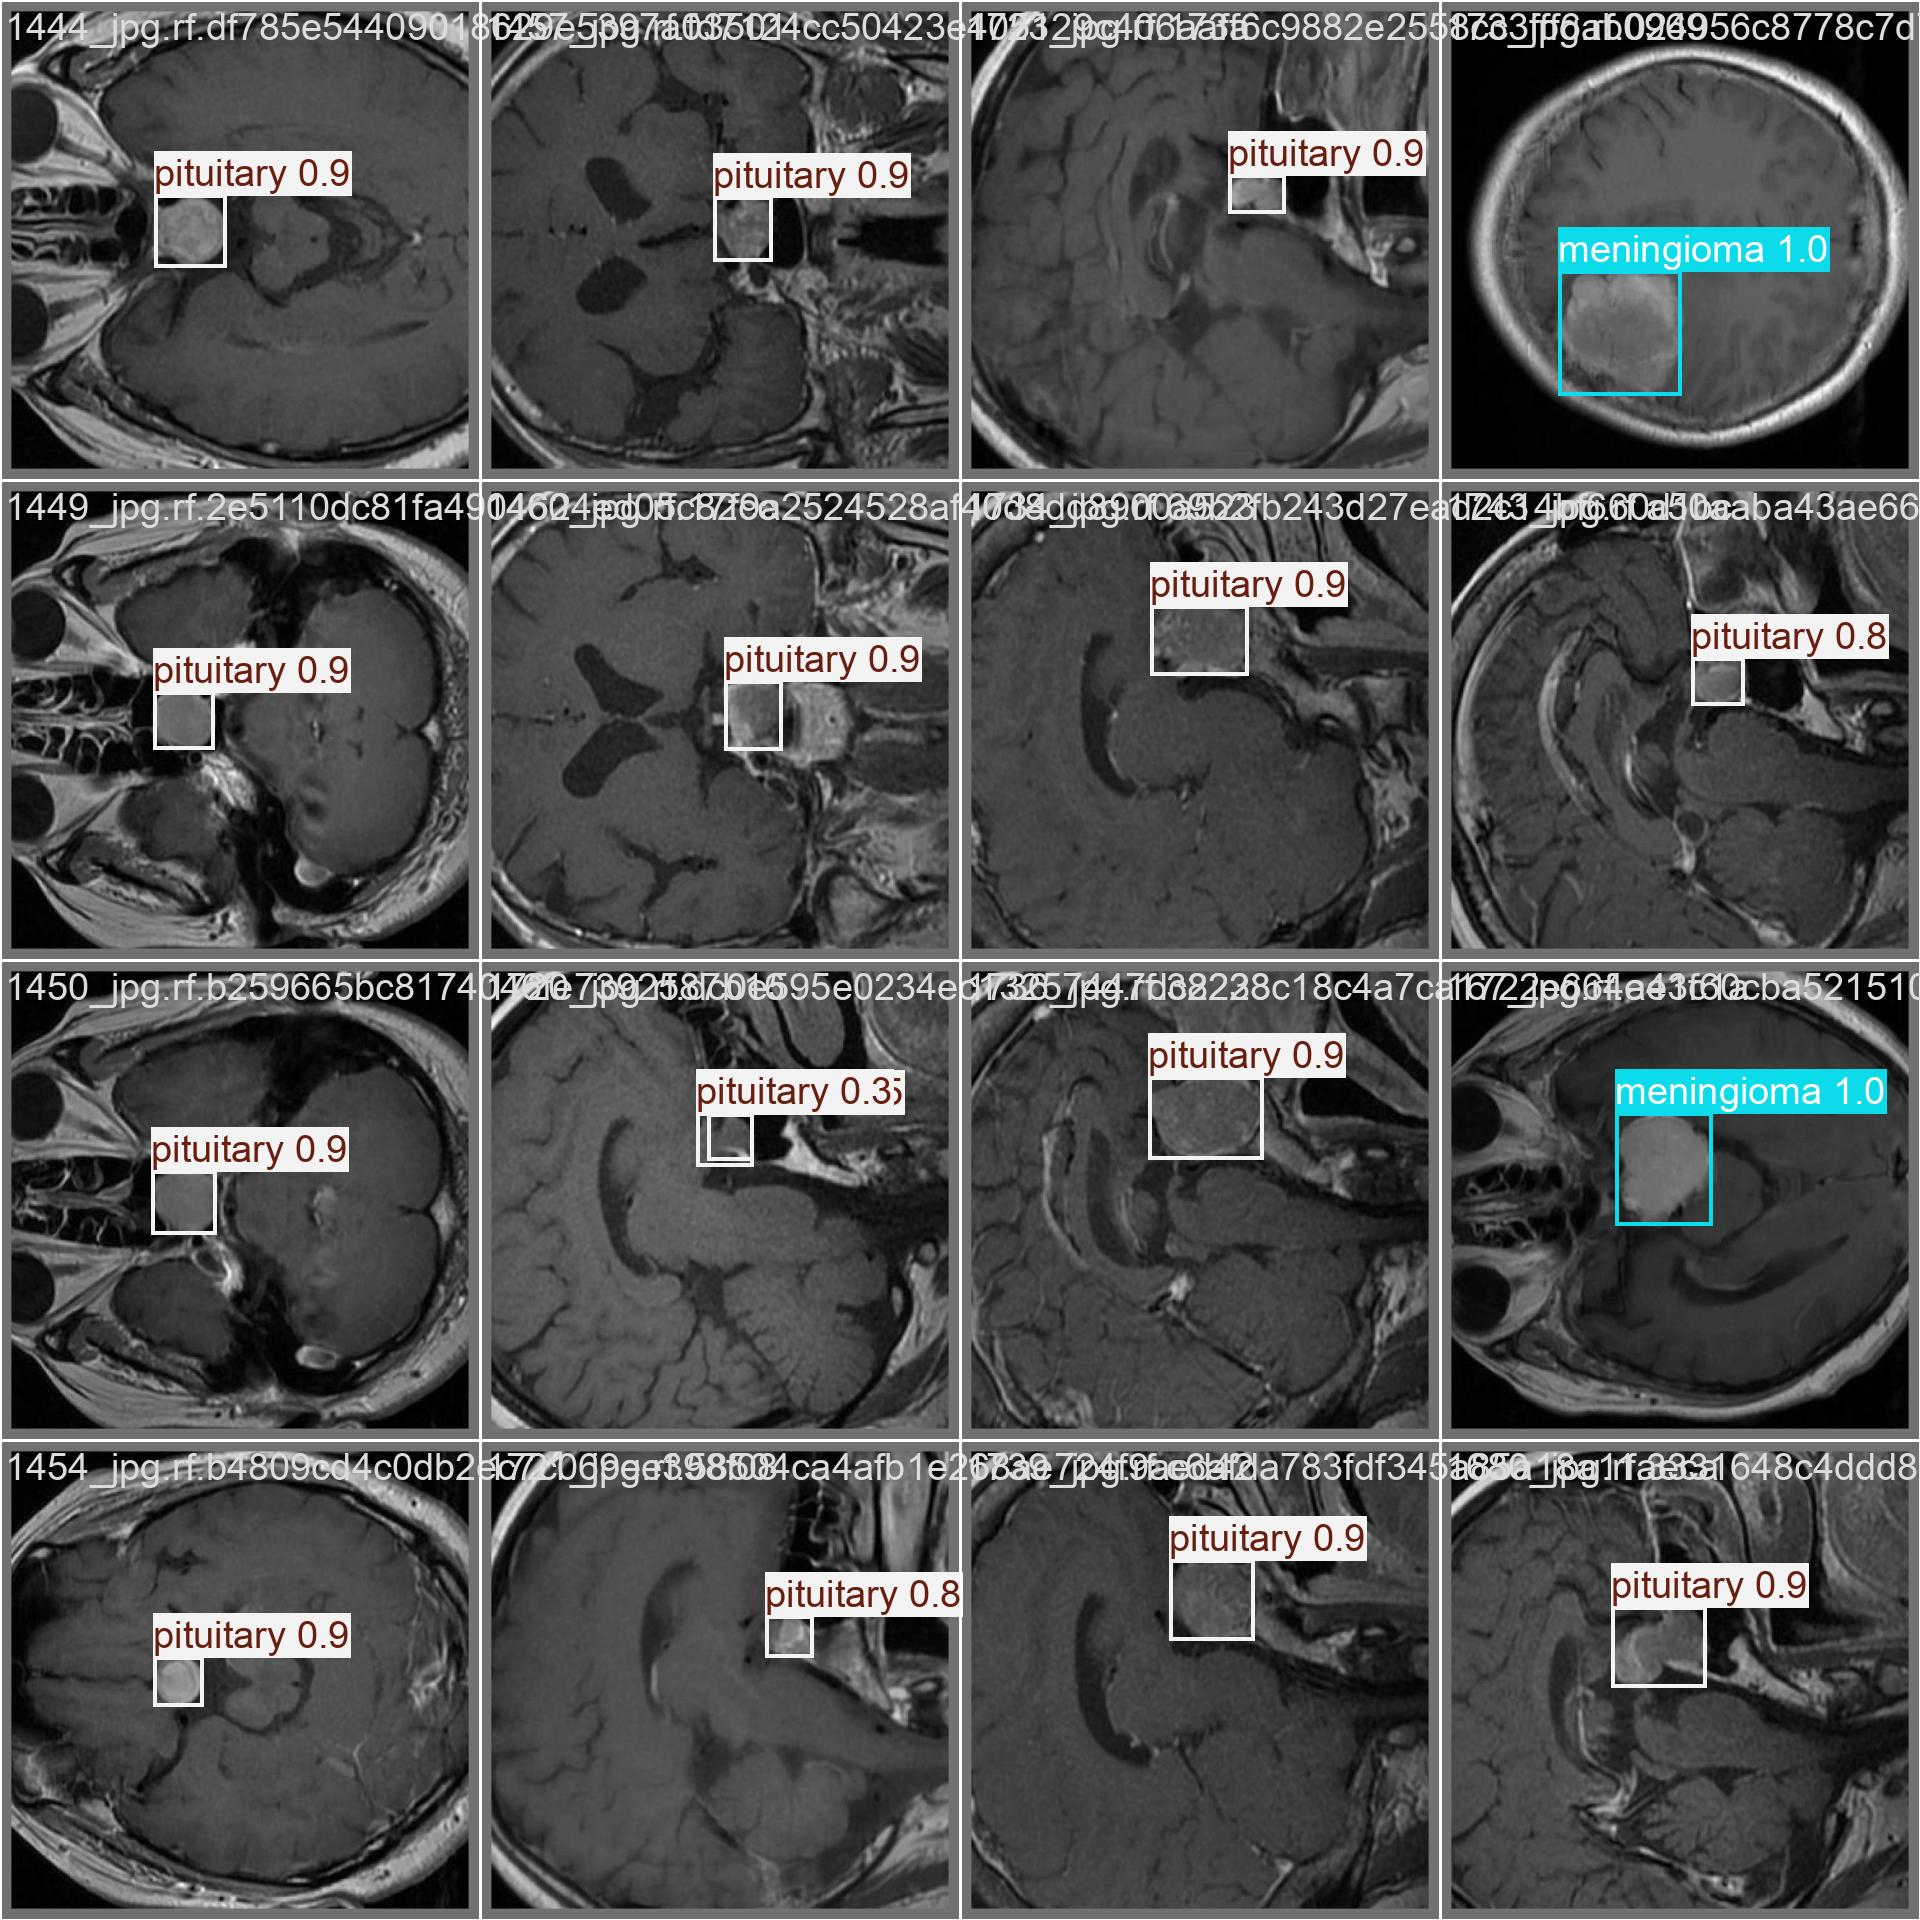

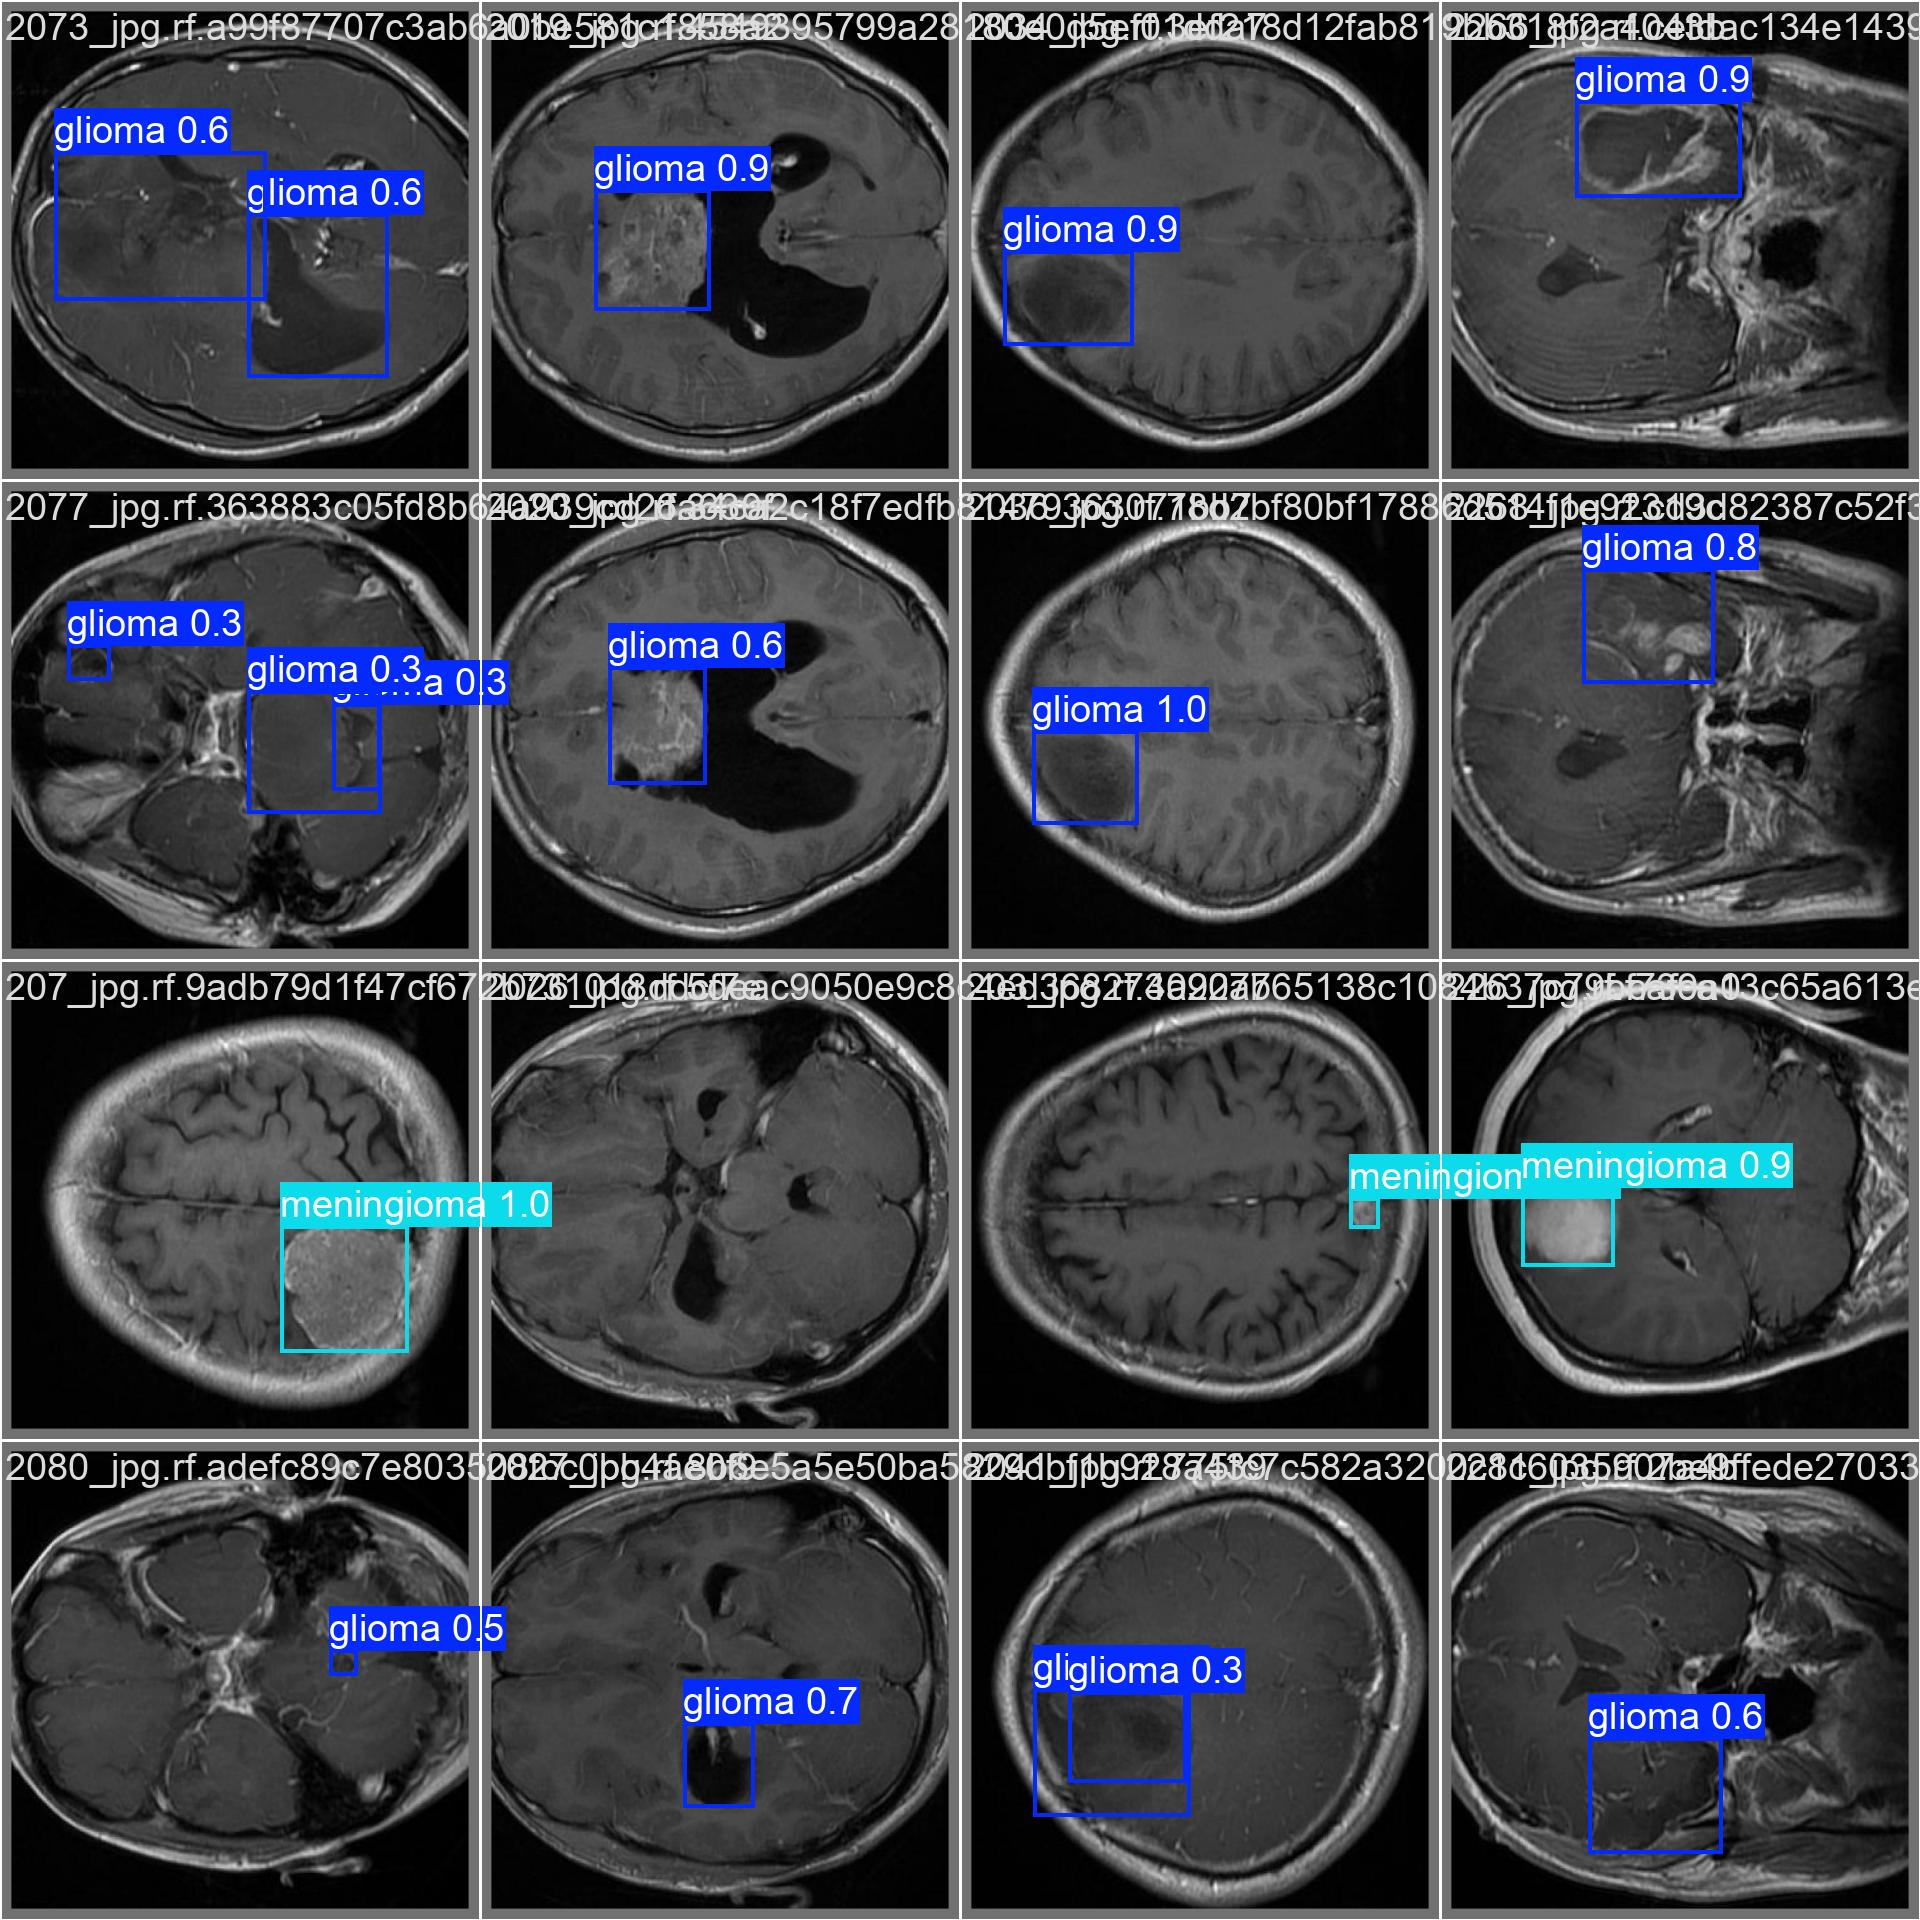


✅ DINO SSL Model training and validation complete.


In [7]:
results_dir = results.save_dir
print(f"\n Displaying results from: {results_dir} ---")

# Training & Validation Metrics
results_plot_path = os.path.join(results_dir, 'results.png')
if os.path.exists(results_plot_path):
    print("\n📊 Training & Validation Metrics")
    display(Image(filename=results_plot_path, width=1000))

# Confusion Matrix
confusion_matrix_path = os.path.join(results_dir, 'confusion_matrix.png')
if os.path.exists(confusion_matrix_path):
    print("\n🔀 Confusion Matrix")
    display(Image(filename=confusion_matrix_path, width=700))

# PR Curve
pr_curve_path = glob.glob(os.path.join(results_dir, '*_PR_curve.png'))
if pr_curve_path:
    print("\n📈 Precision-Recall (PR) Curve")
    display(Image(filename=pr_curve_path[0], width=800))

# Sample Predictions
print("\n🖼️ Sample Predictions from Validation")
val_batch_images = glob.glob(os.path.join(results_dir, 'val_batch*_pred.jpg'))
if val_batch_images:
    for img_path in sorted(val_batch_images)[:3]:
        display(Image(filename=img_path))

print("\n✅ DINO SSL Model training and validation complete.")

